# Alibaba Cloud Container Service for Kubernetes (ACK) Deep MNIST Example
In this example we will deploy a tensorflow MNIST model in the Alibaba Cloud Container Service for Kubernetes.

This tutorial will break down in the following sections:

1) Train a tensorflow model to predict mnist locally

2) Containerise the tensorflow model with our docker utility

3) Test model locally with docker

4) Set-up and configure Alibaba Cloud environment

5) Deploy your model and visualise requests

#### Let's get started! 🚀🔥

## Dependencies:

* Helm v3.0.0+
* kubectl v1.14+
* Python 3.6+
* Python DEV requirements


## 1) Train a tensorflow model to predict mnist locally
We will load the mnist images, together with their labels, and then train a tensorflow model to predict the right labels

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
import tensorflow as tf

if __name__ == '__main__':
    
    x = tf.placeholder(tf.float32, [None,784], name="x")

    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))

    y = tf.nn.softmax(tf.matmul(x,W) + b, name="y")

    y_ = tf.placeholder(tf.float32, [None, 10])

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    init = tf.initialize_all_variables()

    sess = tf.Session()
    sess.run(init)

    for i in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_:mnist.test.labels}))

    saver = tf.train.Saver()

    saver.save(sess, "model/deep_mnist_model")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0.9191


## 2) Containerise the tensorflow model with our docker utility

Create a wrapper file that exposes the functionality through a `predict` function:

In [2]:
%%writefile DeepMnist.py
import tensorflow as tf
import numpy as np

class DeepMnist(object):
    def __init__(self):
        self.class_names = ["class:{}".format(str(i)) for i in range(10)]
        self.sess = tf.Session()
        saver = tf.train.import_meta_graph("model/deep_mnist_model.meta")
        saver.restore(self.sess,tf.train.latest_checkpoint("./model/"))

        graph = tf.get_default_graph()
        self.x = graph.get_tensor_by_name("x:0")
        self.y = graph.get_tensor_by_name("y:0")

    def predict(self,X,feature_names):
        predictions = self.sess.run(self.y,feed_dict={self.x:X})
        return predictions.astype(np.float64)

Overwriting DeepMnist.py


Define the dependencies for the wrapper in the requirements.txt:

In [5]:
%%writefile requirements.txt
tensorflow>=1.12.0

Overwriting requirements.txt


You need to make sure that you have added the .s2i/environment configuration file in this folder with the following content:

In [3]:
!mkdir .s2i

mkdir: cannot create directory ‘.s2i’: File exists


In [4]:
%%writefile .s2i/environment
MODEL_NAME=DeepMnist
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Overwriting .s2i/environment


Now we can build a docker image named "deep-mnist" with the tag 0.1

In [10]:
!s2i build . seldonio/seldon-core-s2i-python36:1.2.4 deep-mnist:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## 3) Test model locally with docker
We first run the docker image we just created as a container called "mnist_predictor"

In [3]:
!docker run --name "mnist_predictor" -d --rm -p 5000:5000 deep-mnist:0.1

9087047e368ac8f285e1f742704b4c0c7bceac7d29ee90b3b0a6ef2d61ebd15c


Send some random features that conform to the contract

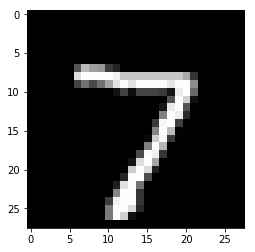

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [6]:
import matplotlib.pyplot as plt
import numpy as np
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

In [7]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np

# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5000"
batch = x
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)

# We use the microservice, instead of the "predict" function
client_prediction = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

LABEL 0:	 0.0064 %
LABEL 1:	 0.0000 %
LABEL 2:	 0.0155 %
LABEL 3:	 0.2862 %
LABEL 4:	 0.0003 %
LABEL 5:	 0.0027 %
LABEL 6:	 0.0000 %
LABEL 7:	 99.6643 %
LABEL 8:	 0.0020 %
LABEL 9:	 0.0227 %


In [8]:
!docker rm mnist_predictor --force

mnist_predictor


## 4) Set-up and configure Alibaba Cloud environment

### 4.1 create a managed kubernetes cluster 
We need to first create a cluster in Alibaba Cloud - you should follow the following instructions (make sure you expose the cluster with an elastic IP by checking the tickbox): https://www.alibabacloud.com/help/doc-detail/95108.htm

You should follow up the instructions but the finished cluster should look as follows:

![](images/k8s-dashboard-2.jpg)

### 4.2 Copy the kubectl configuration to access the cluster

Once you have the cluster created, you will be able to use your local kubectl by copying the configuration details on the overview page, and copy it to your ~/.kube/config

### 4.3 Create an Alibaba Container Registry to push the image
Finally we need to create a container registry repository by following this guide: https://www.alibabacloud.com/blog/up-and-running-with-alibaba-cloud-container-registry_593765

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

#### Fianlly we install the Seldon Analytics Package

In [1]:
!helm install seldon-core-analytics seldon-core-analytics --repo https://storage.googleapis.com/seldon-charts
!kubectl rollout status deployment.apps/grafana-prom-deployment
!kubectl patch svc grafana-prom --type='json' -p '[{"op":"replace","path":"/spec/type","value":"LoadBalancer"}]'

Error: rendered manifests contain a resource that already exists. Unable to continue with install: existing resource conflict: kind: Secret, namespace: default, name: grafana-prom-secret
deployment "grafana-prom-deployment" successfully rolled out
service/grafana-prom patched


### 4.5 Push docker image
We'll now make sure the image is accessible within the Kubernetes cluster by pushing it to the repo that we created in step 4.3. This should look as follows in your dashboard:

![](images/k8s-dashboard-1.jpg)

#### To push the image we first tag it

In [21]:
!docker tag deep-mnist:0.1 registry-intl.eu-west-1.aliyuncs.com/seldonalibaba/deep-mnist:0.1

#### And then we push it

In [22]:
!docker push registry-intl.eu-west-1.aliyuncs.com/seldonalibaba/deep-mnist:0.1

The push refers to repository [registry-intl.eu-west-1.aliyuncs.com/seldonalibaba/deep-mnist]

358e90f3: Preparing 
e4a983d1: Preparing 
74b2c556: Preparing 
9472b523: Preparing 
a2a7ea60: Preparing 
eddb328a: Preparing 
1393f8e7: Preparing 
67d6e30e: Preparing 
f19da2c9: Preparing 
9ec591c4: Preparing 
32b1ff99: Preparing 
64f96dbc: Preparing 
e6d76fd9: Preparing 
11a84ad4: Preparing 


64f96dbc: Pushing  105.6MB/141.8MBPushing     512B/4.43kBPushing  548.9kB/648.8MBPushing  7.426MB/16.85MBPushing  57.75MB/65.26MBPushing  22.51MB/556.5MBPushing  45.06MB/648.8MBPushing   66.6MB/141.8MBPushing  82.16MB/556.5MBPushing  96.63MB/556.5MB4b2c556: Pushing    377MB/648.8MBPushing  72.91MB/648.8MBPushing  158.4MB/556.5MBPushing  103.4MBPushing  197.5MB/556.5MBPushing  266.3MB/556.5MBPushing  176.6MB/648.8MBPushing  268.1MB/648.8MBPushing  269.8MB/648.8MBPushing  280.8MB/648.8MBPushing  404.4MB/556.5MBPushing  422.9MB/556.5MBPushing  345.7MB/648.8MB4b2c556: Pushed   659.3MB/648.8MBPushing  467.2MB/648.8MB0.1: digest: sha256:13ab55662f0e8479bb51d998a8014f7f059a73422295bcd400f62615d36355dc size: 3482


## 5 - Deploy your model and visualise requests

**IMPORTANT: Make sure you replace the URL for your repo in the format of:**
* registry-intl.**[REPO]**.aliyuncs.com/**[REGISTRY]**/**[REPO]**:0.1

In [24]:
%%writefile deep_mnist_deployment.yaml
---
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: deep-mnist
spec:
  annotations:
    project_name: Tensorflow MNIST
    deployment_version: v1
  name: deep-mnist
  oauth_key: oauth-key
  oauth_secret: oauth-secret
  predictors:
  - componentSpecs:
    - spec:
        containers:
        # REPLACE_FOR_IMAGE_AND_TAG
        - image: registry-intl.eu-west-1.aliyuncs.com/seldonalibaba/deep-mnist:0.1 
          imagePullPolicy: IfNotPresent
          name: classifier
          resources:
            requests:
              memory: 1Mi
        terminationGracePeriodSeconds: 20
    graph:
      children: []
      name: classifier
      endpoint:
        type: REST
      type: MODEL
    name: single-model
    replicas: 1
    annotations:
      predictor_version: v1


Overwriting deep_mnist_deployment.yaml


### Run the deployment in your cluster

In [ ]:
kubectl apply -f deep_mnist_deployment.yaml

### And let's check that it's been created.

In [ ]:
!kubectl get pods

### Test the model

We'll use a random example from our dataset

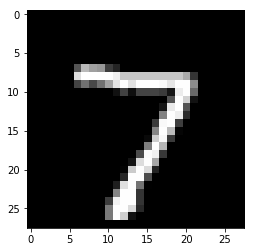

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [28]:
import matplotlib.pyplot as plt
import numpy as np
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

### First we need to find the URL that we'll use 
You need to add it to the script in the next block

In [34]:
!kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].ip}'  

8.208.23.117

We can now add the URL above to send our request:

In [42]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np
import subprocess

# Add the URL you found above, here:
HOST = "8.208.23.117"


port = "80" # Make sure you use the port above
batch = x
payload_type = "ndarray"

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint=HOST + ":" + port,
    namespace="default",
    oauth_key="oauth-key", 
    oauth_secret="oauth-secret")

client_prediction = sc.predict(
    data=batch, 
    deployment_name="deep-mnist",
    names=["text"],
    payload_type=payload_type)

print(client_prediction.response)

meta {
  puid: "krop281g4e1mrsgf60m7ilh1fc"
  requestPath {
    key: "classifier"
    value: "registry-intl.eu-west-1.aliyuncs.com/seldonalibaba/deep-mnist:0.1"
  }
}
data {
  names: "class:0"
  names: "class:1"
  names: "class:2"
  names: "class:3"
  names: "class:4"
  names: "class:5"
  names: "class:6"
  names: "class:7"
  names: "class:8"
  names: "class:9"
  ndarray {
    values {
      list_value {
        values {
          number_value: 4.4009637349518016e-05
        }
        values {
          number_value: 6.321029477618367e-09
        }
        values {
          number_value: 0.0001286377664655447
        }
        values {
          number_value: 0.0030034701339900494
        }
        values {
          number_value: 3.061768893530825e-06
        }
        values {
          number_value: 1.882280412246473e-05
        }
        values {
          number_value: 1.8899024567531342e-08
        }
        values {
          number_value: 0.9959828853607178
        }
        v

### Let's see the predictions for each label
It seems that it correctly predicted the number 7

In [41]:
for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

LABEL 0:	 0.0044 %
LABEL 1:	 0.0000 %
LABEL 2:	 0.0129 %
LABEL 3:	 0.3003 %
LABEL 4:	 0.0003 %
LABEL 5:	 0.0019 %
LABEL 6:	 0.0000 %
LABEL 7:	 99.5983 %
LABEL 8:	 0.0021 %
LABEL 9:	 0.0798 %


#### Finally let's visualise the metrics that seldon provides out of the box
For this we can access the URL with the command below, it will request an admin and password which by default are set to the following:
* Username: admin
* Password: admin

**You will be able to access it at http://[URL]/d/ejAHFXIWz/prediction-analytics?orgId=1**

In [43]:
!kubectl get svc grafana-prom -o jsonpath='{.status.loadBalancer.ingress[0].ip}'  

8.208.25.68

The metrics include requests per second, as well as latency. You are able to add your own custom metrics, and try out other more complex deployments by following furher guides at https://docs.seldon.io/projects/seldon-core/en/latest/examples/notebooks.html

![](images/graf.jpg)